<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/310_subj_prop.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>


(cap-subj-prop)=
# Pensare ad una proporzione in termini soggettivi

Lo scopo di questo capitolo è chiarire il concetto di aggiornamento bayesiano, che abbiamo introdotto nel capitolo precedente. In particolare, esamineremo il modo in cui possiamo rappresentare in modo soggettivo le nostre credenze iniziali riguardo alla probabilità $\theta$ di un evento. Queste credenze iniziali, note come distribuzione a priori, rappresentano le nostre opinioni prima di avere osservato i dati di un esperimento casuale.

Successivamente, considereremo i calcoli necessari per trovare la distribuzione a posteriori di $\theta$, che rappresenta la nostra credenza aggiornata riguardo a $\theta$ dopo aver osservato i dati. La distribuzione a posteriori si ottiene moltiplicando la distribuzione a priori per la verosimiglianza (si veda il capitolo {ref}`cap-likelihood`) e dividendo per una costante di normalizzazione.

In questo capitolo, ci concentreremo sul caso più semplice, ovvero il modello binomiale. Inizieremo analizzando il caso in cui la distribuzione a priori è discreta e, successivamente, esploreremo il caso in cui essa è continua. Per ulteriori dettagli, è possibile consultare il capitolo 7 del libro di {cite:t}`albert_2019prob`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import scipy.stats as st
import arviz as az

In [2]:
%config InlineBackend.figure_format = 'retina'
%load_ext watermark

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

az.style.use("arviz-darkgrid")
sns.set_theme(palette="colorblind")

## Inferenza bayesiana con una distribuzione a priori discreta 

Secondo la visione soggettivista della probabilità, l'incertezza riguardo a un evento rappresentato dalla quantità sconosciuta $\theta$ può essere considerata come un'opinione soggettiva. Questa opinione si basa sia sulle nostre credenze iniziali che sulle nuove informazioni fornite dai dati osservati. L'aggiornamento bayesiano ci permette di combinare le credenze iniziali su $\theta$ con le evidenze dei dati per ottenere una nuova credenza a posteriori su $\theta$.

Nell'esempio discusso da {cite:t}`albert_2019prob`, ci chiediamo quale sia la probabilità che una pallina estratta da un'urna sia rossa. Dato che $\theta$ rappresenta una probabilità, sappiamo che può assumere valori compresi tra 0 e 1. Se non abbiamo informazioni specifiche su $\theta$, potremmo pensare di attribuirgli un valore preciso, come 0.5. Tuttavia, questa posizione è troppo estrema: poiché non abbiamo informazioni certe su $\theta$ non ha senso assegnargli un valore preciso. È più ragionevole invece rappresentare la nostra incertezza su $\theta$ considerando la possibilità che possa assumere diversi valori e assegnando livelli di certezza soggettiva a ciascuno di essi. Ad esempio, possiamo adottare undici possibili valori per $\theta$ e assegnare un certo grado di certezza soggettiva a ognuno di essi. Utilizzando una distribuzione di massa di probabilità, possiamo esprimere in modo completo e preciso la nostra opinione soggettiva su $\theta$. 

Consideriamo i seguenti valori possibili per $\theta$. 

In [25]:
theta = np.linspace(0, 1, 11)
print(theta)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


Se non abbiamo motivi per fare altrimenti, possiamo assegnare la stessa probabilità a ciascun valore di `theta`. È importante notare la seconda linea di codice, che effettua una standardizzazione. Poiché `unif_discr_pdf` è un vettore con un numero finito di elementi, possiamo considerare questi elementi come probabilità e quindi la loro somma deve essere uguale a uno.

In [28]:
unif_distr_pdf = st.uniform.pdf(theta) 
unif_distr_pdf = unif_distr_pdf / np.sum(unif_distr_pdf)
unif_distr_pdf

array([0.09090909, 0.09090909, 0.09090909, 0.09090909, 0.09090909,
       0.09090909, 0.09090909, 0.09090909, 0.09090909, 0.09090909,
       0.09090909])

Text(0, 0.5, 'Probabilità')

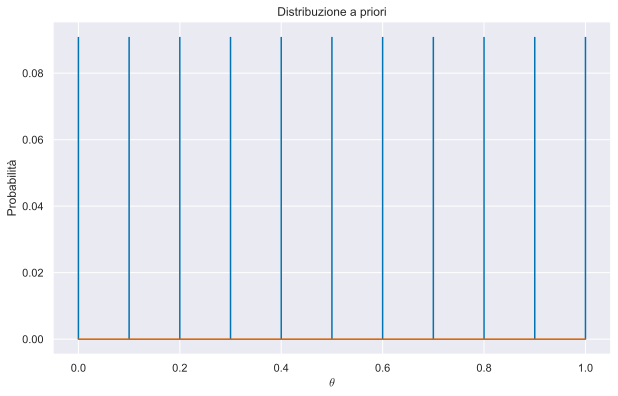

In [29]:
plt.stem(theta, unif_distr_pdf, markerfmt=" ")
plt.title("Distribuzione a priori")
plt.xlabel("$\\theta$")
plt.ylabel("Probabilità")

Oppure, per qualche ragione, potremmo pensare che i valori centrali della distribuzione di $\theta$ siamo più credibili dei valori estremi. Tale opinione soggettiva può essere descritta dalla seguente distribuzione di massa di probabilità.

Text(0, 0.5, 'Probabilità')

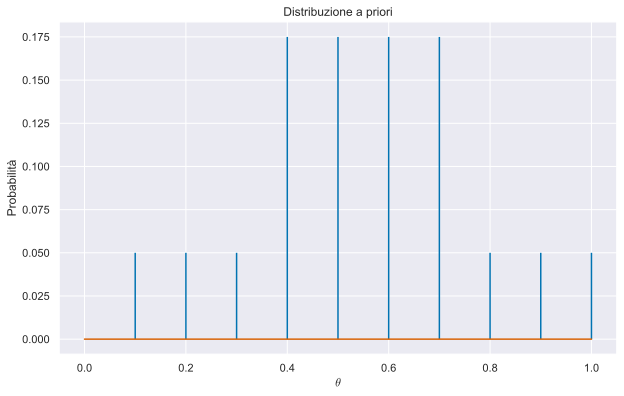

In [30]:
not_unif_distr_pdf = [0, 0.05, 0.05, 0.05, 0.175, 0.175, 0.175, 0.175, 0.05, 0.05, 0.05]
plt.stem(theta, not_unif_distr_pdf, markerfmt=" ")
plt.title("Distribuzione a priori")
plt.xlabel("$\\theta$")
plt.ylabel("Probabilità")

La prima distribuzione di probabilità è una distribuzione discreta uniforme in quanto assegna la stessa probabilità a ogni elemento dell'insieme discreto su cui è definita, ovvero i valori ${0, 0.1, 0.2, \dots, 1.0}$. La seconda distribuzione di probabilità è anch'essa discreta ma non uniforme: si ritiene che $\theta$ abbia una maggiore probabilità di assumere un valore nell'insieme ${0.4, 0.5, 0.6, 0.7}$ rispetto all'insieme ${0.1, 0.2, 0.3, 0.8, 0.9, 1.0}$.

Le credenze iniziali riguardanti i possibili valori di $\theta$ costituiscono la *distribuzione a priori*. L'inferenza bayesiana "aggiorna" queste credenze a priori utilizzando le informazioni fornite dai dati. Queste informazioni vengono combinate con le credenze a priori per $\theta$ mediante il teorema di Bayes, al fine di ottenere la *distribuzione a posteriori*. La distribuzione a posteriori rappresenta la nostra credenza aggiornata sui possibili valori di $\theta$ dopo aver osservato i dati.

Supponiamo di aver osservato l'estrazione di 12 palline rosse su 20 estrazioni con rimessa da un'urna. Per ottenere la distribuzione a posteriori, utilizzeremo come esempio la seconda delle due distribuzioni a priori descritte in precedenza. Secondo il teorema di Bayes, la distribuzione a posteriori è data dal prodotto della verosimiglianza e della distribuzione a priori, diviso per una costante di normalizzazione:

$$
p(\theta \mid y) = \frac{p(y \mid \theta)p(\theta)}{p(y)}.
$$

Per calcolare la funzione di verosimiglianza, $p(y \mid \theta)$, dobbiamo capire come sono stati generati i dati. Nel nostro caso, i dati corrispondono ai risultati di 20 estrazioni con rimessa da un'urna. Se l'estrazione è casuale con reinserimento, allora i dati (cioè 12 successi su 20 prove) possono essere considerati come il risultato di un esperimento casuale binomiale. Utilizzando Python, la funzione di verosimiglianza può essere calcolata tramite la funzione `binom.pmf()`.

In [31]:
lk = st.binom.pmf(12, 20, theta)
lk = lk / np.sum(lk)
lk

array([0.00000000e+00, 1.13872974e-07, 1.81785999e-04, 8.10438314e-03,
       7.45436212e-02, 2.52278752e-01, 3.77377083e-01, 2.40229925e-01,
       4.65372158e-02, 7.47120582e-04, 0.00000000e+00])

Per i 10 valori $\theta$ considerati, la funzione di verosimiglianza assume la forma indicata dalla figura seguente.

Text(0, 0.5, '$L(\\theta)$')

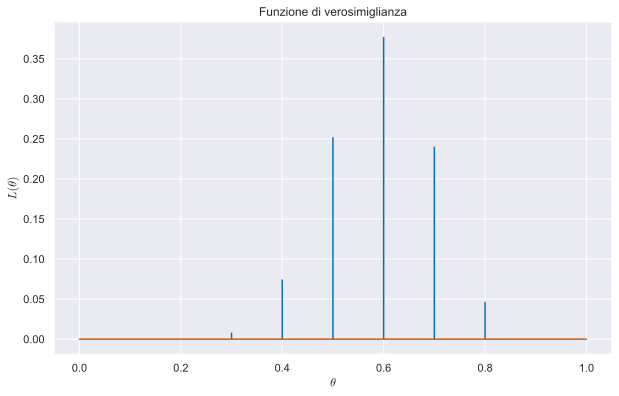

In [32]:
plt.stem(theta, lk, markerfmt=" ")
plt.title("Funzione di verosimiglianza")
plt.xlabel("$\\theta$")
plt.ylabel("$L(\\theta)$")

Per calcolare la distribuzione a posteriori, eseguiamo una moltiplicazione elemento per elemento tra il vettore contenente i valori della distribuzione a priori e il vettore contenente i valori della funzione di verosimiglianza. Successivamente, il risultato viene normalizzato dividendo per la probabilità marginale dei dati $y$, che rappresenta una costante di normalizzazione.

La probabilità marginale dei dati $y$ può essere ottenuta mediante la legge della probabilità totale, che prevede la somma dei prodotti tra la distribuzione a priori e la funzione di verosimiglianza.

In [33]:
np.sum(not_unif_distr_pdf * lk)

0.1680536725817584

La distribuzione a posteriori di $\theta$ si ottiene moltiplicando la distribuzione a priori per la funzione di verosimiglianza e dividendo il risultato per la costante di normalizzazione, cioè la probabilità marginale dei dati.

In [34]:
post = (not_unif_distr_pdf * lk) / np.sum(not_unif_distr_pdf * lk)
print(post)

[0.00000000e+00 3.38799421e-08 5.40856966e-05 2.41124845e-03
 7.76248059e-02 2.62706437e-01 3.92975580e-01 2.50159584e-01
 1.38459383e-02 2.22286300e-04 0.00000000e+00]


Verifichiamo di avere ottenuto una distribuzione di massa di probabilità:

In [35]:
np.sum(post)

1.0000000000000002

Esaminiamo la distribuzione a posteriori di $\theta$.

Text(0, 0.5, 'Probabilità')

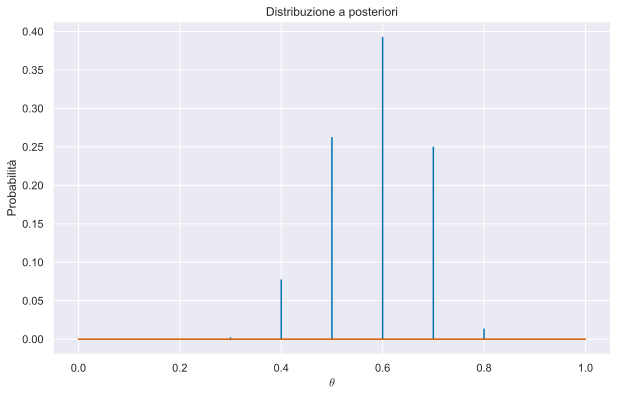

In [36]:
plt.stem(theta, post, markerfmt=" ")
plt.title("Distribuzione a posteriori")
plt.xlabel("$\\theta$")
plt.ylabel("Probabilità")

Una volta conosciuta la distribuzione a posteriori di $\theta$, possiamo calcolare altre quantità di interesse. Ad esempio, la moda a posteriori di $\theta$ si ottiene direttamente dal grafico precedente ed è pari a 0.6. Per calcolare la media a posteriori, possiamo utilizzare la formula del valore atteso delle variabili casuali.

In [37]:
np.sum(theta * post)

0.5853112012901504

La varianza della distribuzione a posteriori è

In [38]:
np.sum(theta**2 * post) - (np.sum(theta * post)) ** 2


0.00881740948606241

Con questo metodo, possiamo calcolare la distribuzione a posteriori di $\theta$ per qualsiasi distribuzione a priori discreta.

## Inferenza bayesiana con una distribuzione a priori continua 

Per scopi didattici, abbiamo discusso il caso di una distribuzione a priori discreta. Tuttavia, è importante notare che l'uso di una distribuzione a priori continua come la distribuzione Beta è più appropriato in quanto consente di rappresentare un'ampia gamma di possibili valori per il parametro sconosciuto $\theta$, senza limitarsi a un insieme discreto di valori. Inoltre, la distribuzione Beta ha il vantaggio di avere un supporto definito sull'intervallo [0, 1], che corrisponde all'intervallo dei possibili valori per la proporzione $\theta$.

Prendiamo ad esempio la distribuzione Beta(2, 2) che ha una forma simmetrica. Per valutare la distribuzione in specifici valori come 0.5, 0.8 e 1.2, possiamo utilizzare la funzione `beta.pdf`. Ad esempio, la densità di probabilità della distribuzione Beta(2, 2) in corrispondenza del valore 0.5 è pari a 1.5, il che indica che i valori di $\theta$ intorno a 0.5 sono considerati più plausibili rispetto ai valori intorno a 0.8, dove la funzione assume il valore 0.96. È importante notare che la densità di probabilità della distribuzione Beta(2, 2) in corrispondenza del valore 1.2 è pari a 0, poiché il valore 1.2 non rientra nell'intervallo di definizione della distribuzione (0 e 1).

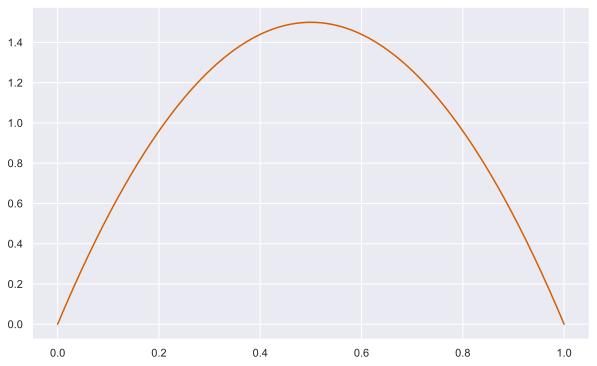

In [39]:
a = 2
b = 2
theta = np.linspace(0, 1, 1000)
_ = plt.plot(theta, st.beta.pdf(theta, a, b), 'r-')

Utilizziamo la funzione `st.beta.pdf()` per generare la distribuzione a priori discretizzata. Come fatto in precedenza, procediamo poi normalizzando i valori ottenuti. Per fare un esempio, usiamo una Beta(2, 5) quale distribuzione a priori.

In [15]:
prior = st.beta.pdf(theta, 2, 5) 
prior = prior / np.sum(prior)

Per calcolare la verosimiglianza, seguiamo la stessa procedura illustrata nel capitolo {ref}`cap-likelihood`. Inoltre, normalizziamo i valori discretizzati della verosimiglianza, come già fatto in precedenza. 

In [16]:
lk = st.binom.pmf(12, 20, theta)
lk = lk / np.sum(lk)

Infine, otteniamo la distribuzione a posteriori moltiplicando la distribuzione a priori per la verosimiglianza e dividendo per la costante di normalizzazione.

In [17]:
post = (prior * lk) / np.sum(prior * lk)

In [18]:
np.sum(post)

1.0

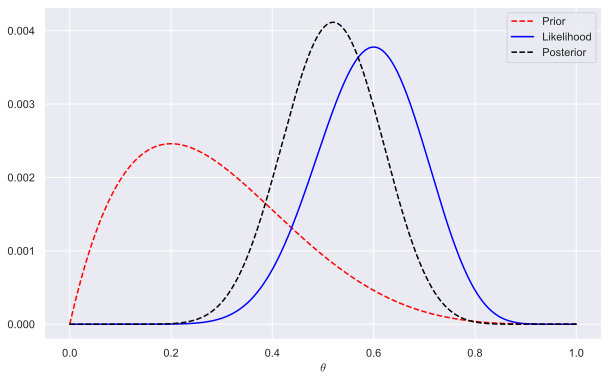

In [19]:
plt.plot(theta, prior, linestyle="solid", color="red", label="Prior")
plt.plot(theta, lk, linestyle="solid", color="blue", label="Likelihood")
plt.plot(theta, post, linestyle="solid", color="black", label="Posterior")
# plt.ylim(0, 7)
plt.xlabel(r"$\theta$")
plt.ylabel("")
# plt.xticks([0, 1], ["West", "East"])
plt.legend()
plt.show()

## Metodo basato su griglia

Il metodo che abbiamo usato in questo capitolo per generare la distribuzione a posteriori è detto metodo basato su griglia. Il metodo numerico esatto basato su griglia consiste nel calcolo della distribuzione a posteriori utilizzando una griglia di punti uniformemente spaziati. Nonostante la maggior parte dei parametri siano continui, l'approssimazione della distribuzione a posteriori può essere ottenuta considerando solo una griglia finita di valori dei parametri. Il metodo prevede quattro fasi:

1. fissare una griglia discreta di possibili valori dei parametri;
2. valutare la distribuzione a priori e la funzione di verosimiglianza per ciascun valore della griglia;
3. calcolare la densità a posteriori approssimata, moltiplicando la distribuzione a priori per la funzione di verosimiglianza per ciascun valore della griglia e normalizzando i prodotti in modo che la loro somma sia uguale a 1;
4. selezionare $n$ valori casuali della griglia per ottenere un campione casuale delle densità a posteriori normalizzate.

Questo metodo può essere migliorato aumentando il numero di punti della griglia, ma il limite principale è che al crescere della dimensionalità dello spazio dei parametri, i punti della griglia necessari per una buona stima aumentano esponenzialmente, rendendo il metodo impraticabile per problemi complessi.

In sintesi, l'approccio basato sulla griglia è intuitivo e non richiede competenze di programmazione avanzate per essere implementato. Inoltre, fornisce un risultato che può essere considerato, per tutti gli scopi pratici, come un campione casuale estratto dalla distribuzione di probabilità a posteriori condizionata ai dati.  Tuttavia, questo metodo ha un uso limitato a causa della *maledizione della dimensionalità*[^036_posterior_sim-1], il che significa che può essere applicato solo a modelli statistici semplici con non più di due parametri. Pertanto, in pratica, viene spesso sostituito da altre tecniche più efficienti, poiché i modelli utilizzati in psicologia spesso richiedono la stima di centinaia o addirittura migliaia di parametri.

[^036_posterior_sim-1]: Per comprendere la maledizione della dimensionalità, possiamo considerare l'esempio di una griglia di 100 punti equispaziati. Nel caso di un solo parametro, sarebbe necessario calcolare solo 100 valori. Tuttavia, se abbiamo due parametri, il numero di valori da calcolare diventa $100^2$. Se invece abbiamo 10 parametri, il numero di valori da calcolare sarebbe di $10^{10}$. È evidente che la quantità di calcoli richiesta diventa troppo grande persino per un computer molto potente. Pertanto, per modelli che richiedono la stima di un numero significativo di parametri, è necessario utilizzare un approccio diverso.

## Commenti e considerazioni finali 

In questo capitolo abbiamo introdotto l'aggiornamento bayesiano per il caso di una distribuzione a priori discreta. Abbiamo anche fornito anticipazioni sul caso di una distribuzione a priori continua. Nel caso continuo, il calcolo della distribuzione a posteriori richiede un integrale non risolvibile analiticamente. Tuttavia, esistono eccezioni, come nel caso dell'inferenza sulla proporzione, in cui la distribuzione a priori è una Beta e la verosimiglianza è binomiale. In tali casi, è possibile ottenere analiticamente le proprietà della distribuzione a posteriori. Nel prossimo capitolo approfondiremo questo argomento.

## Watermark

In [ ]:
%watermark -n -u -v -iv -w